In [1]:
import numpy as np
np.random.seed(42)
import pandas as pd
from scipy.stats import ttest_ind
from numba import njit, jit
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
meta = pd.read_csv('../data/META_SL.csv')

In [3]:
meta['plat'].unique()

array(['Agilent', 'Illumina_NGS', 'Affymetrix_U133', 'Illumina_Chip',
       'Affymetrix_HUG', 'Affymetrix_PRV'], dtype=object)

In [4]:
meta

,CN,type,plat,TP
0,C_1,Solid tumor,Agilent,Solid tumor_Agilent
1,C_2,Solid tumor,Agilent,Solid tumor_Agilent
2,C_3,Solid tumor,Agilent,Solid tumor_Agilent
3,C_4,Solid tumor,Agilent,Solid tumor_Agilent
4,C_5,Solid tumor,Agilent,Solid tumor_Agilent
...,...,...,...,...
7162,C_7163,C,Affymetrix_PRV,C_Affymetrix_PRV
7163,C_7164,D,Affymetrix_PRV,D_Affymetrix_PRV
7164,C_7165,D,Affymetrix_PRV,D_Affymetrix_PRV
7165,C_7166,D,Affymetrix_PRV,D_Affymetrix_PRV


#### Данные, на которых нужно проверить гипотезу

In [5]:
data = pd.read_csv('../data/31.csv')

In [6]:
data.head()

,S9bcbf828_bd0c_4a71_8021_7a262de8978c,S23ea1a02_938c_47cc_8a7d_abd33db1f305,Sddfe7bdf_0d22_4f98_b712_09df67794990,Sb80aec3c_742c_4e9d_b45b_53809b6b80f1,S988b3794_2640_4ff6_a739_d473adbca3e8,S5d095a36_74db_44ec_bca2_35af7a47f1c5,S97e6b861_062c_4235_8f12_db621f22e353,S9120d8d8_8605_493d_a963_7642852778c4,S10aa11ee_6df1_42f6_bc32_6ffed2e7d25c,S3e1fc047_a69e_469b_a005_33b208fdbfd3,...,AFX_GPL16043_B_3,AFX_GPL16043_B_4,AFX_GPL16043_C_1,AFX_GPL16043_C_2,AFX_GPL16043_C_3,AFX_GPL16043_C_4,AFX_GPL16043_D_1,AFX_GPL16043_D_2,AFX_GPL16043_D_3,AFX_GPL16043_D_4
A2M,270.848393,191.669676,199.923537,422.565473,347.636881,224.001590,262.829515,260.432083,286.877833,138.365139,...,279.845564,274.667520,507.395619,505.698826,503.775383,530.761119,422.397457,430.284747,434.087755,410.811390
AACS,61.979214,59.950188,57.344273,76.370544,67.960223,52.241092,49.751346,60.182896,62.213244,91.653534,...,25.065334,20.697204,24.446584,23.028174,23.000603,24.593100,18.752774,20.519499,18.184639,18.210776
AAK1,30.920409,31.597539,28.345749,28.076595,28.584923,26.817384,27.274752,28.826847,27.866762,32.773397,...,200.970280,189.462645,84.642540,76.075727,74.070032,78.915207,143.305889,148.390578,154.894274,163.905300
AAMP,94.361948,77.718508,80.438407,95.791628,136.285935,75.969030,78.065524,76.054874,105.999198,158.769796,...,72.091424,72.019964,61.289467,62.741361,58.500243,65.412935,65.440619,67.981170,68.960307,71.233858
AANAT,32.763587,26.675234,21.060938,22.676344,26.357685,15.612325,15.650893,24.689080,21.538416,39.511073,...,13.626450,13.168662,9.724574,10.180173,9.350852,10.132554,12.843537,12.624136,13.070794,12.286682


In [7]:
data.columns = meta['CN']

In [8]:
data.head()

CN,C_1,C_2,C_3,C_4,C_5,C_6,C_7,C_8,C_9,C_10,...,C_7158,C_7159,C_7160,C_7161,C_7162,C_7163,C_7164,C_7165,C_7166,C_7167
A2M,270.848393,191.669676,199.923537,422.565473,347.636881,224.001590,262.829515,260.432083,286.877833,138.365139,...,279.845564,274.667520,507.395619,505.698826,503.775383,530.761119,422.397457,430.284747,434.087755,410.811390
AACS,61.979214,59.950188,57.344273,76.370544,67.960223,52.241092,49.751346,60.182896,62.213244,91.653534,...,25.065334,20.697204,24.446584,23.028174,23.000603,24.593100,18.752774,20.519499,18.184639,18.210776
AAK1,30.920409,31.597539,28.345749,28.076595,28.584923,26.817384,27.274752,28.826847,27.866762,32.773397,...,200.970280,189.462645,84.642540,76.075727,74.070032,78.915207,143.305889,148.390578,154.894274,163.905300
AAMP,94.361948,77.718508,80.438407,95.791628,136.285935,75.969030,78.065524,76.054874,105.999198,158.769796,...,72.091424,72.019964,61.289467,62.741361,58.500243,65.412935,65.440619,67.981170,68.960307,71.233858
AANAT,32.763587,26.675234,21.060938,22.676344,26.357685,15.612325,15.650893,24.689080,21.538416,39.511073,...,13.626450,13.168662,9.724574,10.180173,9.350852,10.132554,12.843537,12.624136,13.070794,12.286682


In [9]:
data = data.astype(float)

In [10]:
data.head()

CN,C_1,C_2,C_3,C_4,C_5,C_6,C_7,C_8,C_9,C_10,...,C_7158,C_7159,C_7160,C_7161,C_7162,C_7163,C_7164,C_7165,C_7166,C_7167
A2M,270.848393,191.669676,199.923537,422.565473,347.636881,224.001590,262.829515,260.432083,286.877833,138.365139,...,279.845564,274.667520,507.395619,505.698826,503.775383,530.761119,422.397457,430.284747,434.087755,410.811390
AACS,61.979214,59.950188,57.344273,76.370544,67.960223,52.241092,49.751346,60.182896,62.213244,91.653534,...,25.065334,20.697204,24.446584,23.028174,23.000603,24.593100,18.752774,20.519499,18.184639,18.210776
AAK1,30.920409,31.597539,28.345749,28.076595,28.584923,26.817384,27.274752,28.826847,27.866762,32.773397,...,200.970280,189.462645,84.642540,76.075727,74.070032,78.915207,143.305889,148.390578,154.894274,163.905300
AAMP,94.361948,77.718508,80.438407,95.791628,136.285935,75.969030,78.065524,76.054874,105.999198,158.769796,...,72.091424,72.019964,61.289467,62.741361,58.500243,65.412935,65.440619,67.981170,68.960307,71.233858
AANAT,32.763587,26.675234,21.060938,22.676344,26.357685,15.612325,15.650893,24.689080,21.538416,39.511073,...,13.626450,13.168662,9.724574,10.180173,9.350852,10.132554,12.843537,12.624136,13.070794,12.286682


#### Код Стьюдента

In [11]:
rng = np.random.default_rng()

In [12]:
def get_splitted_columns(columns):
    shuffled = rng.permutation(columns)
    columns_1 = shuffled[:len(columns) // 2]
    columns_2 = shuffled[len(columns) // 2:]
    return columns_1, columns_2

In [13]:
def split_for_f(gene, columns_1, columns_2):
    sample_1 = gene[columns_1].values
    sample_2 = gene[columns_2].values
    return f(sample_1, sample_2)

$$
f_g = sign(\overline{D}_g - \overline{H}_g) \cdot (-lg(P_g))
$$

In [14]:
# @njit
def f(sample_1, sample_2):
    sign = np.sign(sample_1.mean() - sample_2.mean())
    p_value = ttest_ind(sample_1, sample_2)[1]
    return sign * (-np.log1p(p_value))

In [15]:
def calc_corr(data, fixed_cols, splitting_cols):
    cols_1, cols_2 = get_splitted_columns(splitting_cols)
    
    f_1 = data.apply(split_for_f, args=(fixed_cols, cols_1), axis=1)
    f_2 = data.apply(split_for_f, args=(fixed_cols, cols_2), axis=1)
    
    return f_1.corr(f_2)

In [18]:
# %time calc_corr(data, plat_1, plat_2)

#### Перебор всех пар платформ

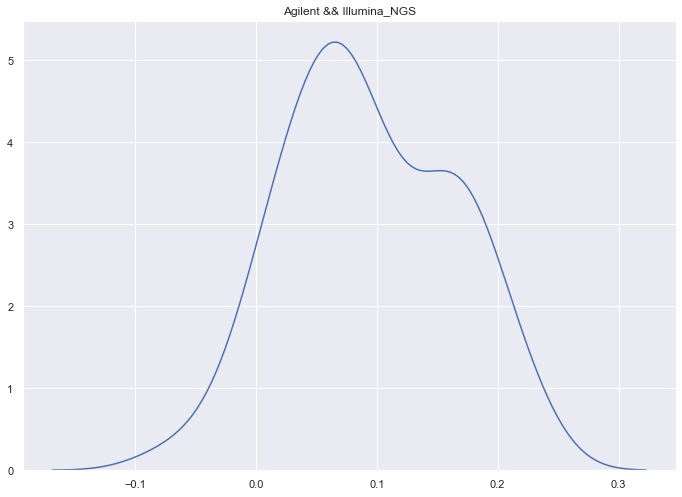

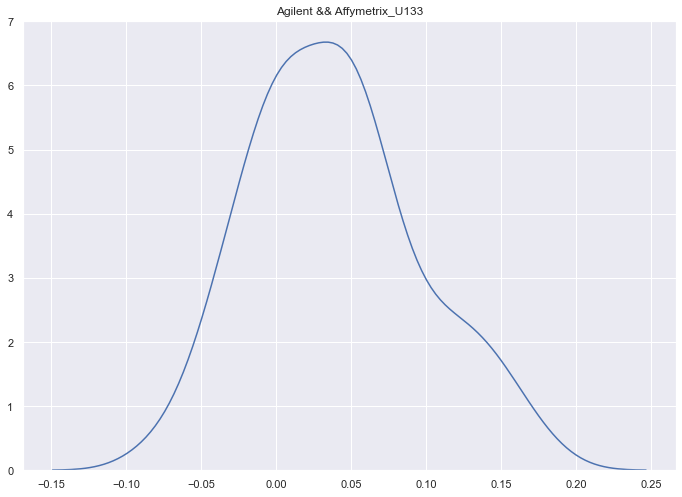

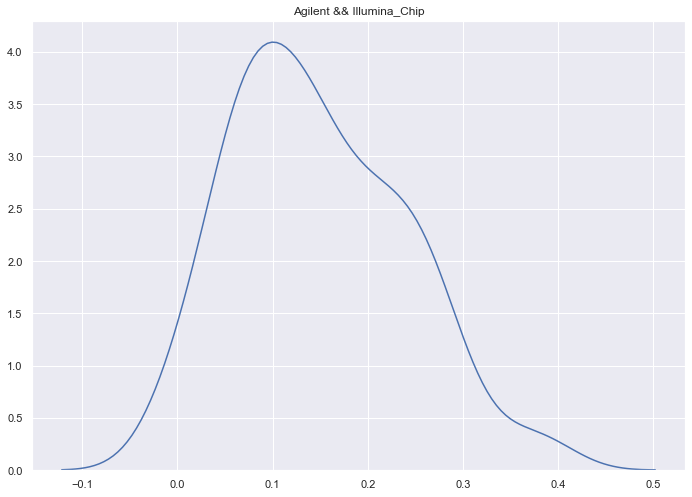

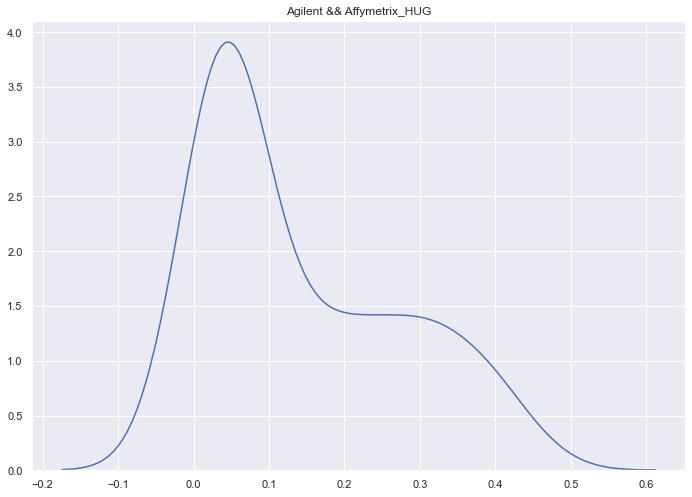

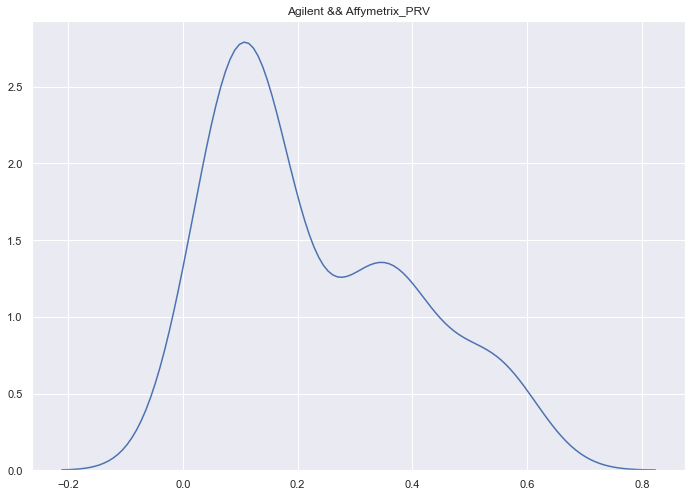

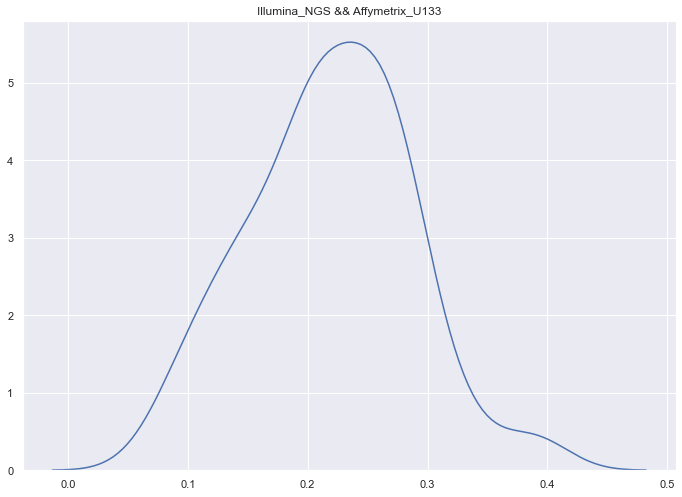

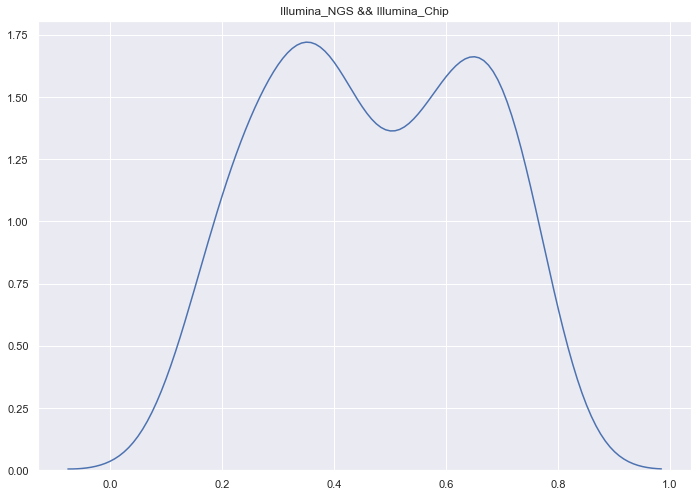

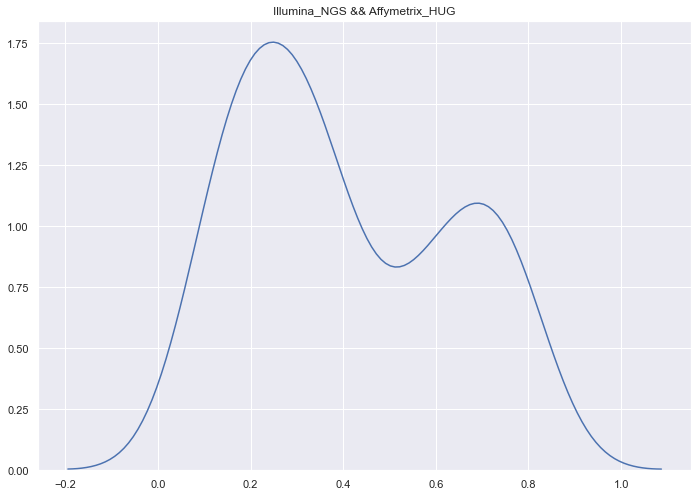

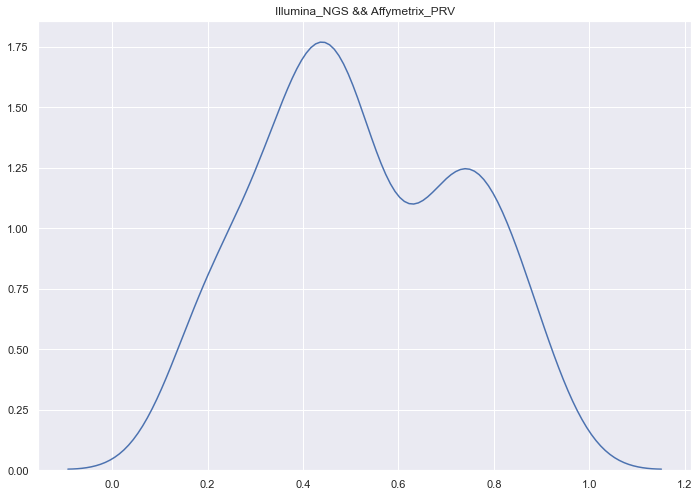

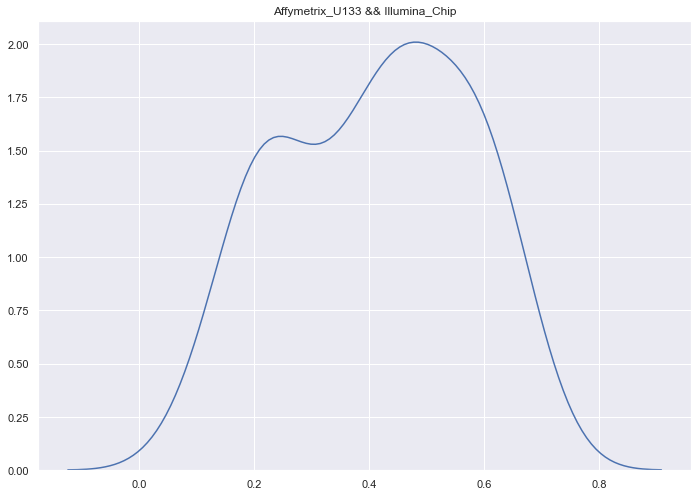

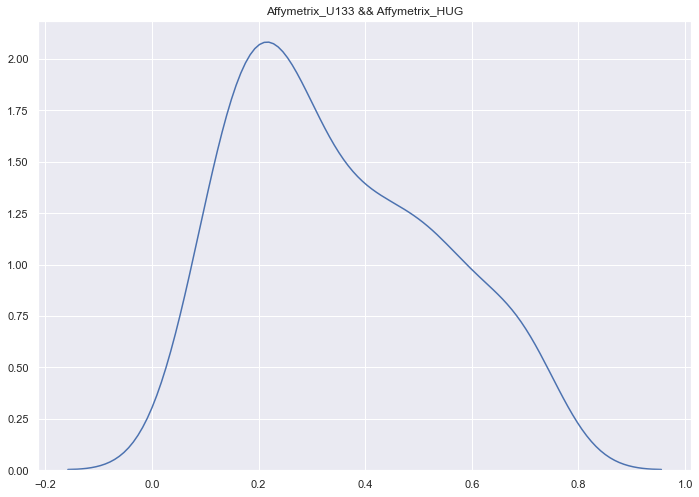

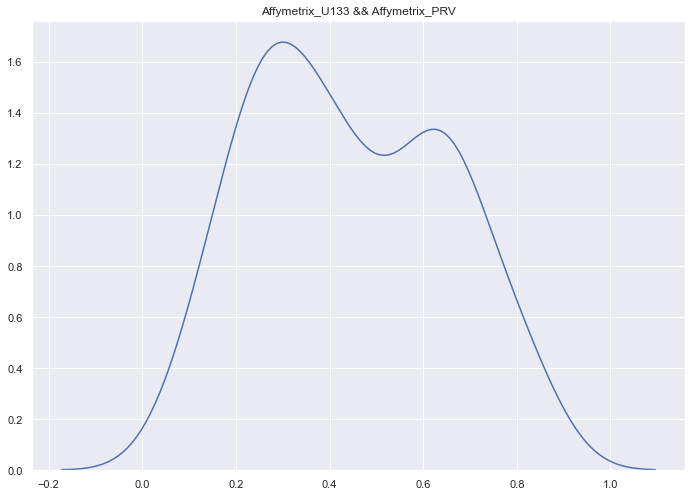

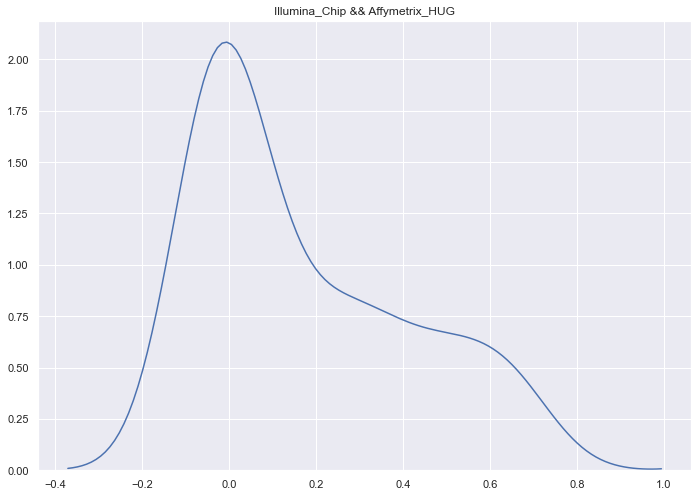

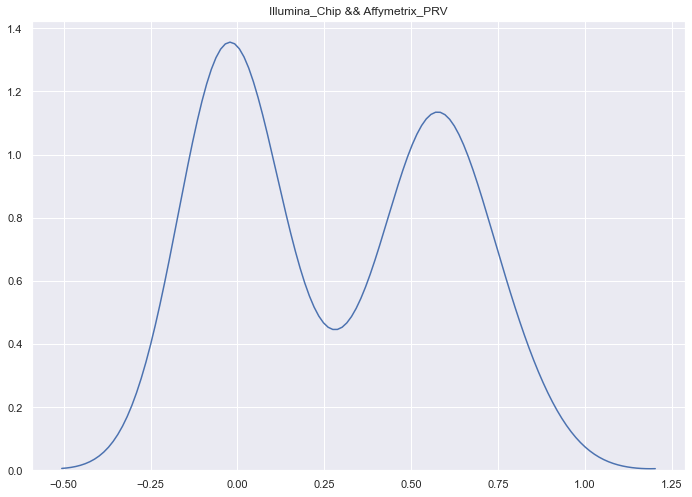

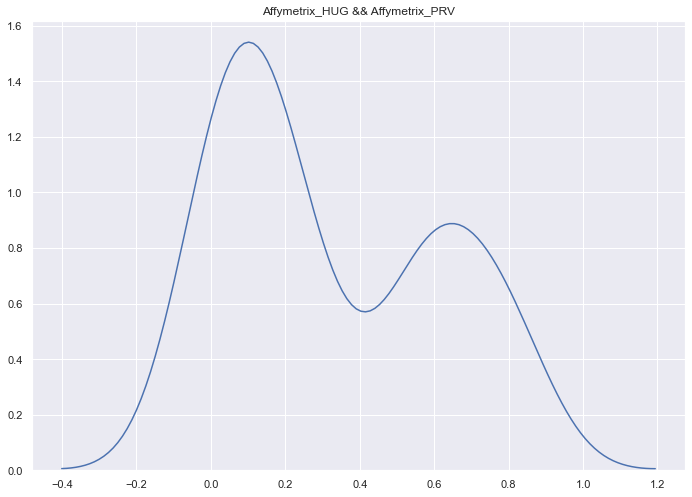

In [16]:
for idx_1, title_1 in enumerate(meta['plat'].unique()):
    for idx_2, title_2 in enumerate(meta['plat'].unique()):
        
        if(idx_2 > idx_1):
            
            plat_1 = meta[meta['plat'] == title_1]['CN']
            plat_2 = meta[meta['plat'] ==  title_2]['CN']
            
            corrs = [calc_corr(data, plat_1, plat_2) for i in range(100)]
            
            plt.figure()
            plt.title(title_1 + " && " + title_2)
            sns.distplot(corrs, hist=False)